<a href="https://colab.research.google.com/github/LuFengjiao/SAML/blob/main/SAML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [4]:
import numpy as np
import math
from typing import List
import os
from torchvision import transforms
import torchvision.datasets as datasets
import torch.utils.data as loader
from torchvision import models
import torch
import pandas as pd
from pandas.core.frame import DataFrame
import os, json, cv2, random
from PIL import Image
from pycocotools.cocoeval import COCOeval
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)



# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is November 26**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name:Lu Fengjiao **
**Neptun ID:D0XK5B** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip 

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: 

In [ ]:
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
# initialize COCO api for instance annotations
print(annFile)
coco = COCO(annFile)
 # display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]                              
print('COCO categories: \n{}\n'.format(' '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

./annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
person animal food outdoor appliance accessory furniture electronic indoor vehicle kitchen sports


In [ ]:
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
path2data="./val2017" 
coco_test = datasets.CocoDetection(root = path2data, 
                                annFile = annFile)
print('number of samples:',len(coco_test))


loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
number of samples: 5000


#### Pre-processing the dataset

In [ ]:
sampler = torch.utils.data.RandomSampler(coco_test)
batch_sampler = torch.utils.data.BatchSampler(sampler, 3, drop_last=True)
 
 # define coco collate_fn
def collate_fn_coco(batch):
    return tuple(zip(*batch))

# creat dataloader
data_loader = torch.utils.data.DataLoader(
        coco_test, batch_sampler=batch_sampler, num_workers=3,
        collate_fn=collate_fn_coco)
 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
targets=[]
img,target=coco_test[0]
for i in range(len(coco_test)):
  img,target=coco_test[i]
  targets.append(target)

In [ ]:
targets[0][3]['bbox']

[358.98, 218.05, 56.0, 102.83]

#### Loading the dataset
Show some images and annotations of your dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


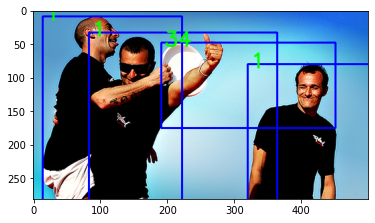

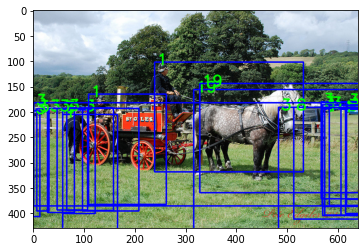

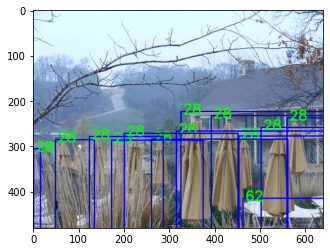

In [ ]:
for d in random.sample(list(data_loader), 1):
  imgs,labels=d
  for i in range(len(imgs)):
        bboxes = []
        ids = []
        img = imgs[i]
        labels_ = labels[i]
        for label in labels_:
            bboxes.append([label['bbox'][0],
            label['bbox'][1],
            label['bbox'][0] + label['bbox'][2],
            label['bbox'][1] + label['bbox'][3]
            ])
            ids.append(label['category_id'])
 
      #  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        for box ,id_ in zip(bboxes,ids):
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            img=np.array(img)
            cv2.rectangle(img,(x1,y1),(x1+x2,y1+y2),(0,0,255),thickness=2)
            cv2.putText(img, text=str(id_), org=(x1 + 5, y1 + 5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                        thickness=2, lineType=cv2.LINE_AA, color=(0, 255, 0))
        #cv2.imshow('test',img)
       # cv2.waitKey()
        plt.imshow(img)
        plt.show()

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

### **Model1---------YOLOv5**

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.0-106-g4c7b2bd torch 1.10.0+cu111 CPU


Setup complete ✅


In [ ]:
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')

!unzip -q tmp.zip -d ../datasets && rm tmp.zip

  0%|          | 0.00/780M [00:00<?, ?B/s]

In [ ]:

!python val.py --data coco.yaml --weights yolov5s.pt --img 640 --iou 0.75


val: data=/content/yolov5/data/coco.yaml, weights=['yolov5s.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.75, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-106-g4c7b2bd torch 1.10.0+cu111 CPU

100% 14.0M/14.0M [00:00<00:00, 103MB/s] 

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
val: Scanning '../datasets/coco/val2017' images and labels...4952 found, 48 missing, 0 empty, 0 corrupted: 100% 5000/5000 [00:02<00:00, 1781.61it/s]
val: New cache created: ../datasets/coco/val2017.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 157/157 [29:37<00:00, 11.32s/it]
                 all       5000      36335      0.642      0.498      0.538      0.351
Speed: 2.5ms pre-process, 334.0ms inference, 14.5ms NMS per image at shape (32, 3, 640

In [ ]:
im1 = cv2.imread("./yolov5/runs/val/exp/val_batch0_labels.jpg")
cv2_imshow(im1)
im2 = cv2.imread("./yolov5/runs/val/exp/val_batch0_pred.jpg")
cv2_imshow(im2)

NameError: ignored

# Metrics for Yolo


In [5]:
df_pred = pd.read_json('/content/yolov5/runs/val/exp/yolov5s_predictions.json')
#df_pred.set_index(["image_id"], inplace=True)
#df_pred.sort_index(axis=0, inplace=True)

In [7]:
filedir = "./annotations/instances_val2017.json"
annos = json.loads(open(filedir).read())
print(type(annos))  # <class 'dict'>
print(len(annos))  # 5
print(annos.keys())  
print(annos["info"])   
print(annos["images"]) 
print(annos["licenses"])
print(annos["annotations"])
print(annos["categories"])

<class 'dict'>
5
dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
{'description': 'COCO 2017 Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
[{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}, {'license': 1, 'file_name': '000000037777.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg', 'height': 230, 'width': 352, 'date_captured': '2013-11-14 20:55:31', 'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg', 'id': 37777}, {'license': 4, 'file_name': '000000252219.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000252219.jpg', 'height': 428, 'width': 640, 'date_captured': '2013-11-14 22:32:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
gt_list=annos["annotations"]

In [10]:
with open("./yolov5/runs/val/exp/yolov5s_predictions.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)

In [11]:
def IOU(box1, box2):
  """
  :box1:[x1,y1,x2,y2]# (x1,y1)表示左上角，(x2,y2)表示右下角
  :box2:[x1,y1,x2,y2]
  :return: iou_ratio交并比
  """
  width1 = abs(box1[2] - box1[0])
  height1 = abs(box1[1] - box1[3])
  width2 = abs(box2[2] - box2[0])
  height2 = abs(box2[1] - box2[3])
  xmax = max(box1[0], box1[2], box2[0], box2[2])
  ymax = max(box1[1], box1[3], box2[1], box2[3])
  xmin = min(box1[0], box1[2], box2[0], box2[2])
  ymin = min(box1[1], box1[3], box2[1], box2[3])
  W = xmin + width1 + width2 - xmax
  H = ymin + height1 + height2 - ymax
  if W <= 0 or H <= 0:  # 当H和W都小于等于0的时候没有交集，其他情况有交集。
    iou_ratio = 0
  else:  # 其他情况有交集
    iou_area = W * H  # 交集的面积
    box1_area = width1 * height1
    box2_area = width2 * height2
    iou_ratio = iou_area / (box1_area + box2_area - iou_area)  # 并集的面积
  return iou_ratio

In [ ]:
print(len(load_erase))
print(len(targets))
print(len(load_dict))
print(len(gt_list))

17693
5000
1179581
36781


In [ ]:
ious=[]
matches=[]
for i in range(len(targets)):
  for j in range(len(targets[i])):
    for m in range(len(load_erase)):
      if targets[i][j]['image_id']==load_erase[m]['image_id']:
        ious=[]
        iou_b=[]
        ious_single=IOU(targets[i][j]['bbox'],load_erase[m]['bbox'])
        iou_b.append(ious_single)
        small={}
        small={'ious_single':ious_single,'imageid':load_erase[m]['image_id'],'catid':load_erase[m]['category_id'],
             'scores':load_erase[m]['score']}
        ious.append(small) 
    Ious=max(iou_b)
    max_index = iou_b.index(max(iou_b))
match={'imageid_gt':targets[i][j]['image_id'],'catid_gt':targets[i][j]['category_id'],
              'Ious':Ious,'imageid_pred':ious[max_index]['image_id'],'catid_pred':ious[max_index]['category_id'],
              'scores':ious[max_index]['score']}
matches.append(match)



KeyboardInterrupt: ignored

In [ ]:

maxIous=[]
cId=[]
sco=[]
imgss=[]
matches=[]
for i in range(len(gt_list)):
  for j in range(len(load_erase)):
    small={}
    if gt_list[i]['image_id']==load_erase[j]['image_id']:
      ious=[] 
      ious_single=IOU(gt_list[i]['bbox'],load_erase[j]['bbox'])
      iou_b=[]
      iou_b.append(ious_single)
      
      small={'ious_single':ious_single,'imageid':load_erase[j]['image_id'],'catid':load_erase[j]['category_id'],
             'scores':load_erase[j]['score']}
      ious.append(small) 
      Ious=max(iou_b)
      max_index = iou_b.index(max(iou_b))
      maxIous.append(Ious)
      cId.append(ious[max_index]['catid'])
      sco.append(ious[max_index]['scores'])
      imgss.append(ious[max_index]['imageid'])

match={'imageid_gt':gt_list[i]['image_id'],'catid_gt':gt_list[i]['category_id'],
             'Ious':maxIous[i],'imageid_pred':imgss[i],'catid_pred':cId[i],
              'scores':sco[i]}
matches.append(match)

KeyboardInterrupt: ignored

In [ ]:
matches

[]

In [ ]:
iou_b=[]
ious=[]
maxIous=[]
cId=[]
sco=[]
imgss=[]
matches=[]
for i in range(len(targets)):
  for j in range(len(targets[i])):
    for m in range(len(load_erase)):
      if targets[i][j]['image_id']==load_erase[m]['image_id']:
        ious=[]
        iou_b=[]
        ious_single=IOU(targets[i][j]['bbox'],load_erase[m]['bbox'])
        iou_b.append(ious_single)
        small={}
        small={'ious_single':ious_single,'imageid':load_erase[m]['image_id'],'catid':load_erase[m]['category_id'],
             'scores':load_erase[m]['score']}
        ious.append(small) 
        Ious=max(iou_b)
        max_index = iou_b.index(max(iou_b))
        maxIous.append(Ious)
        cId.append(ious[max_index]['catid'])
        sco.append(ious[max_index]['scores'])
        imgss.append(ious[max_index]['imageid'])

match={'imageid_gt':targets[i][j]['image_id'],'catid_gt':targets[i][j]['category_id'],
             'Ious':Ious,'imageid_pred':ious[max_index]['image_id'],'catid_pred':ious[max_index]['category_id'],
              'scores':ious[max_index]['score']}
matches.append(match)


In [12]:
def get_max_iou(pred_boxes, gt_box):
    """
    calculate the iou multiple pred_boxes and 1 gt_box (the same one)
    pred_boxes: multiple predict  boxes coordinate
    gt_box: ground truth bounding  box coordinate
    return: the max overlaps about pred_boxes and gt_box
    """
    # 1. calculate the inters coordinate
    if pred_boxes.shape[0] > 0:
        ixmin = np.maximum(pred_boxes[:, 0], gt_box[0])
        ixmax = np.minimum(pred_boxes[:, 2], gt_box[2])
        iymin = np.maximum(pred_boxes[:, 1], gt_box[1])
        iymax = np.minimum(pred_boxes[:, 3], gt_box[3])

        iw = np.maximum(ixmax - ixmin + 1., 0.)
        ih = np.maximum(iymax - iymin + 1., 0.)

    # 2.calculate the area of inters
        inters = iw * ih

    # 3.calculate the area of union
        uni = ((pred_boxes[:, 2] - pred_boxes[:, 0] + 1.) * (pred_boxes[:, 3] - pred_boxes[:, 1] + 1.) +
               (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -
               inters)

    # 4.calculate the overlaps and find the max overlap ,the max overlaps index for pred_box
        iou = inters / uni
        iou_max = np.max(iou)
        nmax = np.argmax(iou)
        return iou, iou_max, nmax

In [27]:
def bbox_list(li):
  bbox_list=[]
  for i in li:
    bbox_list.append(i['bbox'])
  return bbox_list




In [24]:
f=[]
l=[]
for i in range(len(load_dict)-1):
  
#  l.append(load_erase[i])
  if load_dict[i]['image_id']==load_dict[i+1]['image_id']:
    l.append(load_dict[i])
  else:
    l.append(load_dict[i])
    f.append(l)
    l=[]
    #l.append(load_erase[i+1])
     

In [50]:
matched=[] #matched list 
for i in gt_list:
  for j in f:
    if i['image_id']==j[0]['image_id']:
      
      iou, iou_max, nmax=get_max_iou(np.array(bbox_list(j)),np.array(i['bbox']))
      d={'imageid_gt':i['image_id'],'catid_gt':i['category_id'],
             'Ious':iou_max,'imageid_pred':j[nmax]['image_id'],'catid_pred':j[nmax]['category_id'],
              'scores':j[nmax]['score']}
  matched.append(d)


In [51]:
len(matched)

36781

In [ ]:
f=[]
l=[]
for i in range(len(matched)-1):
  
#  l.append(load_erase[i])
  if load_dict[i]['image_id']==load_dict[i+1]['image_id']:
    l.append(load_dict[i])
  else:
    l.append(load_dict[i])
    f.append(l)
    l=[]
    #l.append(load_erase[i+1])

In [53]:
TP=TF=FP=FN=0
for i in matched:
  if i['catid_pred']==i['catid_gt'] and i['Ious'] > 0.5:
    TP+=1
  elif i['catid_pred']==i['catid_gt'] and i['Ious'] < 0.5:
    TF+=1
  elif i['catid_pred']!=i['catid_gt'] and i['Ious'] > 0.5:
    FP+=1
  elif i['catid_pred']!=i['catid_gt'] and i['Ious'] < 0.5:
    FN+=1


In [54]:
print(TP,TF,FP,FN)


2248 13044 2007 19482


In [57]:
p=TP/(TP+FP)
r=TP/(TP+FN)
print(p,r)

0.5283196239717979 0.1034514496088357


[]

In [ ]:
gt.sort_values(by='image_id',axis=0, inplace=True)
gt

In [ ]:
bbx_gt=gt['bbox'].tolist()

In [ ]:
bbx_gt

In [ ]:
for i in range(len(bbx_gt)):
  x=Iou(bbx_gt[i],bbx_pred[i])
  print(x)

In [ ]:
gt.set_index(["image_id"], inplace=True)
gt.sort_index(axis=0, inplace=True)

### **Model2------COCO Detection with Faster R-CNN**

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "../var2017")
register_coco_instances("coco_val", {}, "../annotations/instances_val2017.json", "../val2017")


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
#outputs = predictor(im)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("coco_val", output_dir="../output/R50")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

## **Model3-------COCO Detection with RetinaNet**

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("coco_val", output_dir="../output/RetinaNet")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`


### Question 1
Describe the main differences between the models you chose.

# ----YOLOv5
YOLO belongs to the regression series of Object detection methods

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

Define your metrics manually. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

In [ ]:
# ADD YOUR CODE HERE

#### Show the metrics results

In [ ]:
# ADD YOUR CODE HERE

#### Show some predictions

In [ ]:
# ADD YOUR CODE HERE

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

ADD ANSWERS HERE